In [1]:
from fastai.vision.all import *
import warnings
from PIL import Image

path = Path('inputs')/'processed'
warnings.filterwarnings("ignore")

In [2]:
ims = get_image_files(path)
total_images = len(ims)
print(f"Total images: {total_images}")

Total images: 12643


In [3]:
import torch; print(torch.cuda.get_device_name(0))

# Flush CUDA memory
torch.cuda.empty_cache()

import gc
gc.collect()

NVIDIA GeForce RTX 4070 Ti


66

In [4]:
import os

def _my_grandparent_idxs(items, name):
    def _inner(items, name): 
        return mask2idxs(name in str(Path(o)) for o in items)
    return [i for n in L(name) for i in _inner(items,n)]

def MyGrandparentSplitter(train_name='train', valid_name='valid'):
    "Split `items` from the grand parent folder names (`train_name` and `valid_name`)."
    def _inner(o):
        return _my_grandparent_idxs(o, train_name),_my_grandparent_idxs(o, valid_name)
    return _inner
    


In [5]:
fnames = [
    path/'train/cat/a/9932.png', path/'valid/cat/a/7189.png',
    path/'train/cat/b/9932.png', path/'valid/cat/b/7189.png',
    path/'train/not-a-pet/9932.png', path/'valid/not-a-pet/7189.png',
]
splitter = MyGrandparentSplitter()

In [6]:
def _test_splitter(f, items=None):
    "A basic set of condition a splitter must pass"
    items = ifnone(items, range_of(30))
    trn,val = f(items)
    assert 0<len(trn)<len(items)
    assert all(o not in val for o in trn)
    test_eq(len(trn), len(items)-len(val))
    # test random seed consistency
    test_eq(f(items)[0], trn)
    return trn, val

In [7]:
_test_splitter(splitter, items=fnames)
test_eq(splitter(fnames),[[0,2,4],[1,3,5]])

In [8]:
def parent_label_list(o):
    """
    Returns the parent label of the image as a list
    This is required for a Miltilabel classification problem

    Args:
        o (_type_): _description_

    Returns:
        _type_: _description_
    """
    label = parent_label(o)
    grand_parent_label = o.parent.parent.name
    if label == 'not-a-pet':
        return [label]
    
    return [grand_parent_label[:-1], label]

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_items=get_image_files,
    splitter=MyGrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label_list,
    # not required as i am pre-processing images
    item_tfms=Resize(460), 
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
)

# dblock.summary(path)


In [11]:

dls = dblock.dataloaders(path, bs=32)
print(dls.vocab)


['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'American Wirehair', 'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Chartreux', 'Cheetoh', 'Cornish Rex', 'Devon Rex', 'Egyptian Mau', 'Exotic Shorthair', 'Havana Brown', 'Japanese Bobtail', 'Khao Manee', 'LaPerm', 'Lykoi', 'Maine Coon', 'Manx', 'Munchkin', 'Norwegian Forest Cat', 'Ocicat', 'Oriental Shorthair', 'Persian', 'Peterbald', 'Ragdoll', 'Russian Blue', 'Savannah', 'Scottish Fold', 'Selkirk Rex', 'Siamese', 'Siberian', 'Singapura', 'Snowshoe', 'Somali', 'Sphynx', 'Tonkinese', 'Toyger', 'Turkish Angora', 'Turkish Van', 'cat', 'not-a-pet']


In [12]:
# dls.summary(path)
# dls.show_batch(max_n=9)


Minimum/10: 3.63e-02, steepest point: 6.92e-04
Slide: 1.91e-02, Valley: 3.98e-04


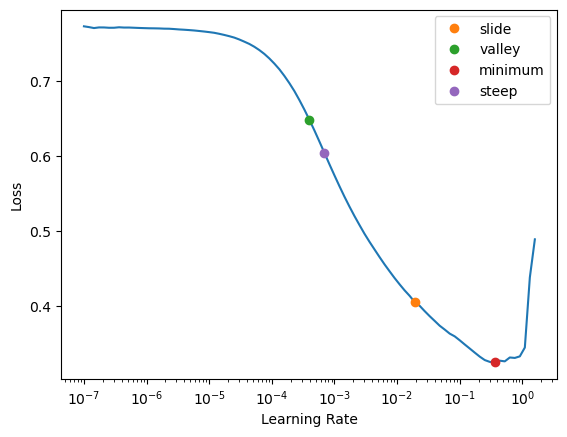

In [31]:
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from fastai.vision.all import *
import timm
from fastai.metrics import F1Score

model = xresnet50(n_out=dls.c)

def custom_accuracy(y_pred, y_true, thresh=0.2, sigmoid=True):
    if sigmoid: y_pred = y_pred.sigmoid()
    return ((y_pred > thresh) == y_true.bool()).float().mean()

# Create the learner
learn = Learner(
    dls,
    model,
    loss_func=BCEWithLogitsLoss(),
    metrics=[accuracy_multi, custom_accuracy],
).to_bf16()


lr_slide, lr_valley, lr_min, lr_steep = learn \
    .lr_find(suggest_funcs=(slide, valley, minimum, steep))
    
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")
print(f"Slide: {lr_slide:.2e}, Valley: {lr_valley:.2e}")

In [32]:
# get a baseline
learn.fine_tune(5, base_lr=lr_slide)
learn.export('xresnet50.pkl')

epoch,train_loss,valid_loss,accuracy_multi,custom_accuracy,time
0,0.116835,0.106294,0.977532,0.973810,00:44


epoch,train_loss,valid_loss,accuracy_multi,custom_accuracy,time
0,0.092021,0.096208,0.977268,0.973231,00:43
1,0.088785,0.093507,0.976903,0.971940,00:45
2,0.083230,0.078485,0.980295,0.978161,00:43
3,0.077190,0.075008,0.980262,0.975216,00:43
4,0.072574,0.071389,0.980527,0.977334,00:45


In [15]:
x, y = dls.one_batch()
print(x.shape)
x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])

torch.Size([32, 3, 224, 224])


(TensorImage([0.5241, 0.4944, 0.4289], device='cuda:0'),
 TensorImage([0.2860, 0.2826, 0.3044], device='cuda:0'))

In [41]:
def get_dls(bs, size):
    dblock = DataBlock(
        blocks=(ImageBlock, MultiCategoryBlock),
        get_items=get_image_files,
        splitter=MyGrandparentSplitter(train_name='train', valid_name='valid'),
        get_y=parent_label_list,
        item_tfms=Resize(460),
        batch_tfms=[
            *aug_transforms(
                size=size,
                min_scale=0.75,
                flip_vert=False,
                max_rotate=10.0,
                max_zoom=1.1,
                max_lighting=0.2,
                max_warp=0.2,
                p_affine=0.75,
                p_lighting=0.75),
            Normalize.from_stats(*imagenet_stats)
        ])

    return dblock.dataloaders(path, bs=bs)

In [44]:
learn = Learner(
    dls,
    model,
    loss_func=BCEWithLogitsLoss(),
    metrics=[accuracy_multi, custom_accuracy],
).to_bf16()

dls = get_dls(64, 224)
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy_multi,custom_accuracy,time
0,0.065975,0.065357,0.981271,0.975232,00:43
1,0.064508,0.064322,0.981519,0.976539,00:43
2,0.061588,0.061235,0.981734,0.975861,00:43
3,0.059604,0.060078,0.981900,0.976010,00:43


In [43]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])


(TensorImage([0.0354, 0.0969, 0.1681], device='cuda:0'),
 TensorImage([1.2530, 1.2451, 1.2740], device='cuda:0'))

In [45]:
# progressive resizing

dls = get_dls(128, 128)
learn.dls = dls
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy_multi,custom_accuracy,time
0,0.067304,0.068523,0.980593,0.973214,00:44
1,0.064425,0.064358,0.981189,0.975481,00:43
2,0.061315,0.062351,0.981470,0.975497,00:46
3,0.059694,0.061811,0.981619,0.975778,00:43


In [46]:
# now replace the dls in the learner

learn.dls = get_dls(64, 224)
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy_multi,custom_accuracy,time
0,0.059253,0.058502,0.982181,0.976606,00:42


epoch,train_loss,valid_loss,accuracy_multi,custom_accuracy,time
0,0.057139,0.057090,0.982231,0.977201,00:43
1,0.056985,0.056667,0.982165,0.976937,00:43
2,0.056079,0.055706,0.982479,0.976804,02:02
3,0.054713,0.055134,0.982529,0.977317,-1:59:27
4,0.054766,0.055008,0.982562,0.977003,00:45


In [47]:
learn.export('xresnet50.pkl')

In [48]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

AssertionError: ==:
1286
60442